## 1. 사용할 패키지 불러오기

In [20]:
import pandas as pd
import numpy as np
import collections
import pyLDAvis.gensim_models
import gensim.corpora as corpora
import gensim
from gensim import models
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import nltk
from nltk.util import ngrams
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jongwook95.lee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. 데이터 불러오기

### (1) 파일 불러오기
- data_dir: 파일 경로

In [21]:
data_dir = './data/bbc-text.csv'

In [22]:
if data_dir.split('.')[-1] in ['txt', 'csv']:
    data = pd.read_csv(data_dir)
elif data_dir.split('.')[-1] in ['xlsx', 'xls']:
    data = pd.read_excel(data_dir)

In [23]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


### (2) 사용할 Text가 저장된 Column 지정
text_col: Column 이름

In [24]:
text_col = 'text'

## 3. 텍스트 전처리

In [25]:
def text_cleaning(data):
 
    # 영문자 이외 문자는 공백으로 변환
    if only_alphabet:
        preprocessed = re.sub('[^a-zA-Z]', ' ', data)
    else:
        preprocessed = data

    # 소문자 변환
    preprocessed = preprocessed.lower().split()
 
    # 불용어 제거
    stops = set(stopwords.words('english'))
    preprocessed = [word for word in preprocessed if not word in stops]

    # 사용자 정의 불용어 제거
    preprocessed = [word for word in preprocessed if not word in custom_stopwords]
 
    # 어간 추출
    if stemming:
        stemmer = nltk.stem.SnowballStemmer('english')
        preprocessed = [stemmer.stem(word) for word in preprocessed]
 
    # 공백으로 구분된 문자열로 결합하여 결과 반환
    return ' '.join(preprocessed)

### (1) Option 설정

- only_alphabet: 오직 영어만 추출 (숫자, 특수문자 제거)
- custom_stopwords_exist: 사용자 설정 불용어 존재 여부
- stemming: 어간 추출 여부
- custom_stopwords: 사용자 설정 불용어 리스트

In [26]:
only_alphabet = True
custom_stopwords_exist = False
stemming = False

In [27]:
custom_stopwords = []

### (2) 텍스트 전처리

In [28]:
preprocessed_text = data[text_col].apply(lambda x : text_cleaning(x))
preprocessed_text[:3]

0    tv future hands viewers home theatre systems p...
1    worldcom boss left books alone former worldcom...
2    tigers wary farrell gamble leicester say rushe...
Name: text, dtype: object

### (3) Tokenize

In [39]:
tokenizer = TreebankWordTokenizer()
Tokens = [tokenizer.tokenize(text) for text in preprocessed_text]
Tokens[:3]

[['tv',
  'future',
  'hands',
  'viewers',
  'home',
  'theatre',
  'systems',
  'plasma',
  'high',
  'definition',
  'tvs',
  'digital',
  'video',
  'recorders',
  'moving',
  'living',
  'room',
  'way',
  'people',
  'watch',
  'tv',
  'radically',
  'different',
  'five',
  'years',
  'time',
  'according',
  'expert',
  'panel',
  'gathered',
  'annual',
  'consumer',
  'electronics',
  'show',
  'las',
  'vegas',
  'discuss',
  'new',
  'technologies',
  'impact',
  'one',
  'favourite',
  'pastimes',
  'us',
  'leading',
  'trend',
  'programmes',
  'content',
  'delivered',
  'viewers',
  'via',
  'home',
  'networks',
  'cable',
  'satellite',
  'telecoms',
  'companies',
  'broadband',
  'service',
  'providers',
  'front',
  'rooms',
  'portable',
  'devices',
  'one',
  'talked',
  'technologies',
  'ces',
  'digital',
  'personal',
  'video',
  'recorders',
  'dvr',
  'pvr',
  'set',
  'top',
  'boxes',
  'like',
  'us',
  'tivo',
  'uk',
  'sky',
  'system',
  'allow',

## 4.1 LDA

### (1) Option 설정
- min_count: 특정 개수 이하 단어는 제거
- N_grams: N_gram 수 (1: Uni-gram)

In [91]:
min_count = 3
N_grams = 2

### (2) LDA 구성 요소 생성

In [92]:
def get_ngrams(token, n):
    n_grams = ngrams(token, n)
    return [' '.join(grams) for grams in n_grams]

In [93]:
if N_grams > 1:
    gram_tokens = [get_ngrams(token, N_grams) for token in Tokens]
else:
    gram_tokens = Tokens

In [96]:
id2word=corpora.Dictionary(gram_tokens)
id2word.filter_extremes(no_below = min_count)
texts = gram_tokens
corpus=[id2word.doc2bow(text) for text in texts]

### (3) 최적의 Topic 개수 확인

In [103]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    plt.show()
    
    return model_list, coherence_values

In [104]:
start_topic_num = 3
end_topic_num = 10
step = 1

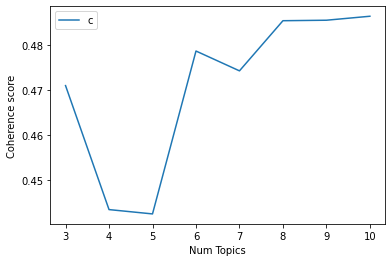

In [105]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start_topic_num, limit=end_topic_num+1, step=step)

In [106]:
best_topic_num = range(start_topic_num, end_topic_num+1, step)[coherence_values.index(max(coherence_values))]
print("Best topic number: {}".format(best_topic_num))

Best topic number: 10


### (4) 최적의 LDA 모델 저장

In [110]:
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=8) 
topics

[(0,
  '0.012*"mr blair" + 0.006*"tony blair" + 0.006*"prime minister" + 0.005*"said mr" + 0.005*"mr brown" + 0.004*"last year" + 0.004*"camera phones" + 0.004*"mobile phone"'),
 (1,
  '0.004*"mr jackson" + 0.004*"six nations" + 0.004*"new zealand" + 0.004*"prime minister" + 0.003*"world cup" + 0.003*"grand slam" + 0.003*"first half" + 0.003*"standard life"'),
 (2,
  '0.011*"p p" + 0.004*"said mr" + 0.004*"kilroy silk" + 0.004*"spider man" + 0.003*"mr kilroy" + 0.003*"video games" + 0.002*"bot nets" + 0.002*"told bbc"'),
 (3,
  '0.008*"mr blair" + 0.006*"prime minister" + 0.003*"michael howard" + 0.003*"last year" + 0.003*"general election" + 0.003*"tony blair" + 0.003*"told bbc" + 0.003*"mr campbell"'),
 (4,
  '0.009*"high definition" + 0.005*"told bbc" + 0.004*"home secretary" + 0.004*"mr blunkett" + 0.003*"prime minister" + 0.003*"bbc news" + 0.003*"said mr" + 0.002*"says mr"'),
 (5,
  '0.004*"chief executive" + 0.004*"mr brown" + 0.004*"bn bn" + 0.003*"last year" + 0.002*"fourth qu

### (5) pyLDAvis 시각화

In [111]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
pyLDAvis.display(vis)

/home/jongwook95.lee/miniforge3/envs/bert_eng/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/jongwook95.lee/miniforge3/envs/bert_eng/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/jongwook95.lee/miniforge3/envs/bert_eng/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jongwook95.lee/miniforge3/envs/bert_eng/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/jong

### (6) 토픽 배정
- prob: 각 토픽에 대한 확률을 배정 (True) vs 가장 확률이 높은 토픽 이름만 배정 (False)
- save_file: 토픽 배정 결과를 csv파일로 저장

In [115]:
prob = True
save_file = False

In [116]:
if prob:
    probability = np.zeros((len(best_model[corpus]), best_topic_num))
    for doc in range(len(best_model[corpus])):
        for topic, proba in best_model[corpus][doc]:
            probability[doc, topic] = proba
        
    probability = pd.DataFrame(probability)
    probability.columns = ['Topic' + str(num) for num in range(1, best_topic_num + 1)]
    if save_file:
        probability.to_csv('topic_porb.csv', index = False)

In [146]:
lda_topic_assignment = [max(p,key=lambda item: item[1]) for p in best_model[corpus]]
lda_topic_assignment = [topic + 1 for (topic, proba) in lda_topic_assignment]

<BarContainer object of 10 artists>

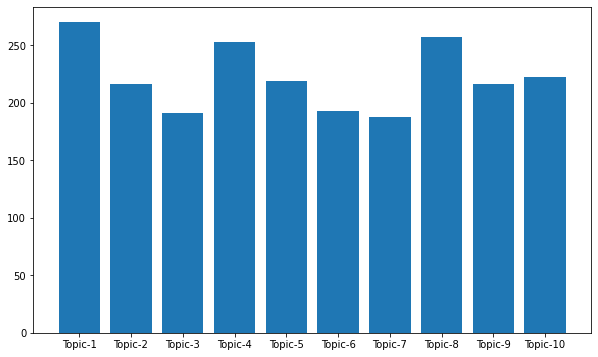

In [154]:
plt.figure(figsize=(10,6))
w = collections.Counter(lda_topic_assignment)
w = sorted(w.items())
keys = [key for (key, value) in w]
values = [value for (key, value) in w]
plt.bar(['Topic-' + str(key) for key in keys], values)

## 4.2 BerTopic

### (1) Option 설정
- nr_topics: 토픽 수 ('auto': 최적)
- language: ['english', 'multilingual']

In [39]:
nr_topics = 10 
language = 'english'

### (2) BerTopic 생성

In [40]:
from bertopic import BERTopic
model = BERTopic(nr_topics=nr_topics, language=language)
topics, probabilities = model.fit_transform(preprocessed_text)

In [41]:
model.get_topic_info().head()

,Topic,Count,Name
0,-1,821,-1_said_mr_would_government
1,0,337,0_england_game_club_side
2,1,274,1_mobile_people_said_technology
3,2,151,2_mr_labour_election_party
4,3,122,3_music_band_album_song


### (3) 시각화

In [42]:
model.visualize_barchart(top_n_topics=10)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.019566469772655835, 0.020280721093526643,
                    0.02400581481619549, 0.02530799594707143, 0.030254728251281483],
              'xaxis': 'x',
              'y': [wales  , side  , club  , game  , england  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.021122540243243497, 0.022220589422197984,
                    0.0249409811753984, 0.025287409610241608, 0.025946592219114554],
              'xaxis': 'x2',
              'y': [games  , technology  , said  , people  , mobile  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.038510635881534264, 0.042762444880819483,
                    0.04909422271712879, 0.0567949359435381, 0.06572727320898723],
              'xaxis': 'x3',
              'y': [blair  , party  , election  , labour  , mr  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.029358098960346305, 0.031121618024622023,
                    0.039072161050347026, 0.043020280689228904,
                    0.05178097244994399],
              'xaxis': 'x4',
              'y': [best  , song  , album  , band  , music  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03324425111983161, 0.03393443671707653, 0.03526850736473189,
                    0.035449605288189336, 0.03752688986972046],
              'xaxis': 'x5',
              'y': [virus  , search  , microsoft  , users  , security  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.030662176647617865, 0.033349599242286344,
                    0.034876992182618735, 0.03518763862523263, 0.04283189064764948],
              'xaxis': 'x6',
              'y': [champion  , world  , athens  , race  , olympic  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03504548563443753, 0.03526419618635194, 0.03721565912707275,
                    0.051859566470130486, 0.05400475451863208],
              'xaxis': 'x7',
              'y': [said  , dollar  , economic  , economy  , growth  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03522709004409476, 0.036958574233989294,
                    0.041466380048654196, 0.07158455963777374, 0.0826978482498562],
              'xaxis': 'x8',
              'y': [awards  , oscar  , actor  , best  , film  ],
              'yaxis': 'y8'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.036484723264400894, 0.03655204520220245,
                    0.03982125701134974, 0.05129561496377979, 0.05371157594871628],
              'xaxis': 'x9',
              'y': [australian  , set  , seed  , roddick  , open  ],
              'yaxis': 'y9'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.042157198489901015, 0.04335913329666962,
                    0.055460119945248375, 0.08851587217982149, 0.09900767718497917],
              'xaxis': 'x10',
              'y': [russia  , gazprom  , russian  , oil  , yukos  ],
              'yaxis': 'y10'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                 

In [43]:
model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'england | game | club | side | wales', 337],
                                   [1, 'mobile | people | said | technology | games', 274],
                                   [2, 'mr | labour | election | party | blair', 151],
                                   [3, 'music | band | album | song | best', 122],
                                   [4, 'security | users | microsoft | search | virus', 101],
                                   [5, 'olympic | race | athens | world | champion', 100],
                                   [6, 'growth | economy | economic | dollar | said', 92],
                                   [7, 'film | best | actor | oscar | awards', 89],
                                   [8, 'open | roddick | seed | set | australian', 87],
                                   [9, 'yukos | oil | russian | gazprom | russia', 51]], dtype=object),
              'hovertemplate': ('<b>Topic %{customdata[0]}</b><' ... '[1]}<br>Size: %{customdata[2]}'),
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([337, 274, 151, 122, 101, 100,  92,  89,  87,  51]),
                         'sizemode': 'area',
                         'sizeref': 0.210625,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ 10.917589 ,   3.4595072,  10.621656 ,  -7.889737 ,   3.0969548,
                           -9.766547 ,  10.6423645,  -7.5954423, -10.023824 ,  10.970123 ],
                         dtype=float32),
              'xaxis': 'x',
              'y': array([-3.7893379, 14.275059 , -3.4928637, -3.8770967, 14.637513 , -9.712836 ,
                           2.2520747, -3.6025891, -9.456308 ,  1.9214996], dtype=float32),
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': -11.527397298812867,
                                'y': 2.8316892147064205,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 0.5441222429275507,
                                'xshift': 10,
                                'y': 16.8331401348114}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 0.5441222429275507,
                           'x1': 0.5441222429275507,
                           'y0': -11.16976170539856,
                           'y1': 16.8331401348114},
                          {'line': {'color': '#9E9E9E', 'width': 2},
                           'type': 'line',
                           'x0': -11.527397298812867,
                           'x1': 12.615641784667968,
                           'y0': 2.8316892147064205,
                           'y1': 2.8316892147064205}],
               'sliders': [{'active': 0,
                            'pad': {'t': 50},
                            'steps': [{'args': [{'marker.color': [['red',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                                                                  '#B0BEC5',
                            